Cumulative trends in labor force participation since the recession of 2001

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os

os.chdir('/home/brian/Documents/CPS/data/clean/')

In [52]:
cols = ['YEAR', 'MONTH', 'AGE', 'FEMALE', 'LFS', 'BASICWGT']

df = pd.concat([pd.read_feather(f'cps{year}.ft', columns=cols)
                  .query('35 <= AGE <= 49')
                  .assign(LF = lambda x: np.where(x.LFS != 'NILF', 
                                                  x.BASICWGT, 0))
                for year in range(1989, 2022)])

In [53]:
conds = [(df.AGE >= a1) & (df.AGE <= a2) & (df.FEMALE == f) 
         for (a1, a2), f in 
         itertools.product([(35, 39), (40, 44), (45, 49)], 
                           [1, 0])]

choice = ['Women, 35-39', 'Men, 35-39', 'Women, 40-44', 'Men, 40-44',
          'Women, 45-49', 'Men, 45-49']

df['Group'] = np.select(conds, choice)

In [48]:
conds = [(df.AGE >= a1) & (df.AGE <= a2) & (df.FEMALE == f) 
         for (a1, a2), f in 
         itertools.product([(25, 34), (35, 44), (45, 54)], 
                           [1, 0])]

choice = ['Women, 25-34', 'Men, 25-34', 'Women, 35-44', 'Men, 35-44',
          'Women, 45-54', 'Men, 45-54']

df['Group'] = np.select(conds, choice)

In [54]:
lfpr = lambda x: (x.LF.sum() / x.BASICWGT.sum())

result = df.groupby(['YEAR', 'MONTH', 'Group']).apply(lfpr).unstack() * 100

<AxesSubplot:xlabel='YEAR,MONTH'>

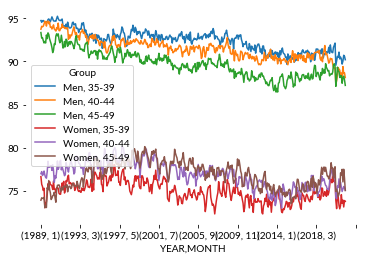

In [55]:
result.plot()

In [43]:
list(itertools.product([(25, 34), (35, 44), (45, 54)], 
                           [1, 0]))

[((25, 34), 1),
 ((25, 34), 0),
 ((35, 44), 1),
 ((35, 44), 0),
 ((45, 54), 1),
 ((45, 54), 0)]

In [36]:
df

,YEAR,MONTH,AGE,FEMALE,LFS,BASICWGT,LF,Group
0,1999,10,39,1,Employed,2748.052490,2748.052490,"Women, 45-54"
1,1999,10,39,0,Employed,4013.454346,4013.454346,"Men, 25-34"
7,1999,10,44,1,Employed,2476.503906,2476.503906,"Women, 45-54"
8,1999,10,43,0,Employed,2866.590820,2866.590820,"Men, 25-34"
9,1999,10,40,0,NILF,2729.879883,0.000000,"Men, 25-34"
...,...,...,...,...,...,...,...,...
436766,2021,3,34,0,Employed,382.218903,382.218903,"Women, 35-44"
436776,2021,3,42,0,NILF,293.221405,0.000000,"Men, 25-34"
436779,2021,3,25,1,Employed,374.105591,374.105591,"Women, 25-34"
436780,2021,3,25,0,Employed,399.787689,399.787689,"Women, 35-44"


In [21]:
conds = [(df.AGE >= 25) & (df.AGE <= 34) & (df.FEMALE == 1),
         (df.AGE >= 35) & (df.AGE <= 44) & (df.FEMALE == 1),
         (df.AGE >= 45) & (df.AGE <= 54) & (df.FEMALE == 1),
         (df.AGE >= 25) & (df.AGE <= 34) & (df.FEMALE == 0),
         (df.AGE >= 35) & (df.AGE <= 44) & (df.FEMALE == 0),
         (df.AGE >= 45) & (df.AGE <= 54) & (df.FEMALE == 0)]
choice = ['Women, 25-34', 'Women, 35-44', 'Women, 45-54',
          'Men, 25-34', 'Men, 35-44', 'Men, 45-54']


df['Group'] = np.select(conds, choice)

In [ ]:
df

In [28]:
itertools.product([(25, 34), (35, 44), (45, 54)], [0, 1])

In [32]:
tot = df.groupby(['YEAR', 'MONTH', 'Group']).BASICWGT.sum()
lfs = df.groupby(['YEAR', 'MONTH', 'Group', 'LFS']).BASICWGT.sum()

(lfs / tot).unstack()

LFS                      Employed      NILF  Unemployed  nan
YEAR MONTH Group                                            
1999 1     Men, 25-34    0.899439  0.068699    0.031861  0.0
           Men, 35-44    0.751176  0.226931    0.021893  0.0
           Men, 45-54    0.864813  0.105580    0.029606  0.0
           Women, 25-34  0.733618  0.229052    0.037330  0.0
           Women, 35-44  0.890088  0.068303    0.041609  0.0
...                           ...       ...         ...  ...
2021 12    Men, 35-44         NaN       NaN         NaN  NaN
           Men, 45-54         NaN       NaN         NaN  NaN
           Women, 25-34       NaN       NaN         NaN  NaN
           Women, 35-44       NaN       NaN         NaN  NaN
           Women, 45-54       NaN       NaN         NaN  NaN

[1656 rows x 4 columns]

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools

os.chdir('/home/brian/Documents/CPS/data/clean/')

# Graph settings
plt.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)
plt.rcParams.update({'axes.titlesize': 16,
                     'axes.titleweight': 'medium', 
                     'font.weight': 'regular'})
plt.rc('font', family='Lato')

In [2]:
sex = {0: 'Men', 1: 'Women'}

ages = [(25, 34), (35, 44), (45, 54)]

age_list = [f'{age_min}-{age_max}' for age_min, age_max in ages]

groups = [(f'{sex[i]} {age}', i, int(age[0:2]), int(age[3:5])) 
          for age, i in itertools.product(age_list, [0, 1])]

queries = [(name, f'{age_min} <= AGE <= {age_max} and FEMALE == {sex}') 
           for name, sex, age_min, age_max in groups]

cols = ['YEAR', 'AGE', 'FEMALE', 'LFS', 'NILFREASON', 'BASICWGT', 'MONTH']

other = ['Other', 'Retired']

calcs = [('Employed', 'LFS', 'Employed'),
         ('Unemployed', 'LFS', 'Unemployed'),
         ('NILF', 'LFS', 'NILF'),
         ('School', 'NILFREASON', 'School'),
         ('Discouraged', 'NILFREASON', 'Discouraged'),
         ('Retired', 'NILFREASON', 'Retired'),
         ('Disabled/Ill', 'NILFREASON', 'Disabled/Ill'),
         ('Caring for Family/Household', 'NILFREASON', 'Family'),
         ('Other', 'NILFREASON', 'Other')]

In [3]:
annual_data = []
for year in range(1999, 2022):
    for month in range(1, 13):
        df = (pd.read_feather(f'cps{year}.ft', columns=cols)
                .query('MONTH == @month'))
        date = pd.to_datetime(f'{year}-{month}-01')
        for name, query in queries:
            data = df.query(query)
            total = data.BASICWGT.sum()
            for calc_name, group_var, var in calcs:
                result = data.groupby(group_var).BASICWGT.sum()[var]
                value = (name, calc_name, date, result / total * 100)
                annual_data.append(value)

<ipython-input-3-a36de9b1bf8e>:12: RuntimeWarning: invalid value encountered in float_scalars
  value = (name, calc_name, date, result / total * 100)
<ipython-input-3-a36de9b1bf8e>:12: RuntimeWarning: invalid value encountered in float_scalars
  value = (name, calc_name, date, result / total * 100)
<ipython-input-3-a36de9b1bf8e>:12: RuntimeWarning: invalid value encountered in float_scalars
  value = (name, calc_name, date, result / total * 100)
<ipython-input-3-a36de9b1bf8e>:12: RuntimeWarning: invalid value encountered in float_scalars
  value = (name, calc_name, date, result / total * 100)
<ipython-input-3-a36de9b1bf8e>:12: RuntimeWarning: invalid value encountered in float_scalars
  value = (name, calc_name, date, result / total * 100)
<ipython-input-3-a36de9b1bf8e>:12: RuntimeWarning: invalid value encountered in float_scalars
  value = (name, calc_name, date, result / total * 100)
<ipython-input-3-a36de9b1bf8e>:12: RuntimeWarning: invalid value encountered in float_scalars
  valu

In [4]:
final = pd.DataFrame(annual_data)
final.columns = ['group', 'category', 'date', 'value']

d = {}
for name, query in queries:
    dft = (final.query(f'group == "{name}"')
                .pivot(index='date', columns='category', values='value'))
    dft = dft[['Unemployed', 'NILF']]
    dft = dft.rolling(12).mean().dropna()
    dft = dft - dft.iloc[0]
    d[name] = dft

In [5]:
colors = ['#a6cee3', '#1f78b4']

# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), 
          ('2008-01-01', '2009-07-01')]

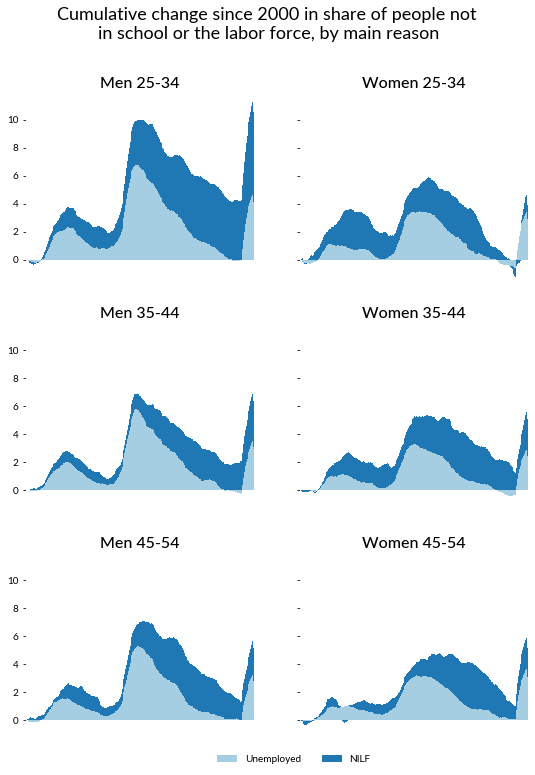

In [6]:
fig, axes = plt.subplots(nrows=len(ages), ncols=2, figsize=(9,12), sharey=True)
for i, ax in enumerate(axes.flatten()):
    d[queries[i][0]].plot(
        kind='bar', stacked=True, ax=ax, legend=None, width=1.0,
        color=colors)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_title(queries[i][0])
ax.legend(bbox_to_anchor=(0.35, 0.0), ncol=2, frameon=False)
fig.suptitle('Cumulative change since 2000 in share of people not \nin school or the labor force, by main reason', fontsize=18);